# Error Analysis

In [1]:
%matplotlib inline

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sys.path.append(os.path.dirname(os.getcwd()))
from sentence import Sentence
from estimator import Estimator

Using TensorFlow backend.


## Getting the prediction results

In [10]:
# Load validation sentences
with open('../data/cdd.epe') as dev_data:
    sentences = [Sentence.from_json(line) for line in dev_data]
    sentences = [s for s in sentences if s.data['negations']]


In [16]:
estimator = Estimator.load('../best_model/')
data_x, data_y = estimator.preprocessor.transform(sentences)
data_x = list(data_x)[:estimator.mode]

pred_y = estimator.model.predict(data_x)

In [17]:
tokens = data_x[0][data_x[0] != 0]

y_true = np.argmax(data_y, axis=-1)[data_x[0] != 0]
y_pred = np.argmax(pred_y, axis=-1)[data_x[0] != 0]

## Cue tag confusion matrix

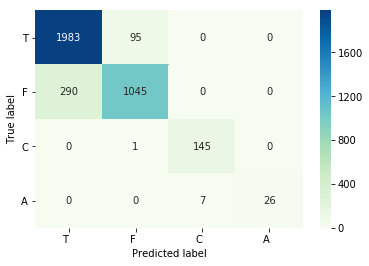

In [35]:
from sklearn.metrics import confusion_matrix
names = [Sentence.Tag(x).name for x in range(len(Sentence.Tag))]
df_cm = pd.DataFrame(confusion_matrix(y_true.ravel(), y_pred.ravel()), columns=names, index=names)

heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="GnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('../figures/confusion_matrix.png')

## Analysis

In [51]:
errors = []
for i, (sentence, y_tr, y_pr) in enumerate(zip(sentences, np.argmax(data_y, axis=-1), np.argmax(pred_y, axis=-1))):
    for token, y, y_ in zip(sentence.forms, y_tr, y_pr):
        if y != y_:
            errors.append([
                token,
                Sentence.Tag(y).name,
                Sentence.Tag(y_).name,
                i
            ])

df_err = pd.DataFrame(errors, columns=['token', 'true_label', 'pred_label', 'sent'])
df_err.head(10)

,token,true_label,pred_label,sent
0,I,F,T,3
1,have,F,T,3
2,had,F,T,3
3,a,F,T,3
4,most,F,T,3
5,It,F,T,5
6,is,F,T,5
7,Private,F,T,8
8,detectives,F,T,8
9,are,F,T,8


In [82]:
from termcolor import colored



,sent,count
0,104,26
1,154,21
2,161,20
3,108,19
4,41,14
5,156,14
6,60,12
7,83,12
8,135,11
9,38,10


## Scopes missclassified as out of scope

In [97]:
df = df_err[df_err['true_label'] == 'F'][df_err['pred_label'] == 'T']
df = df[['token', 'sent']].groupby(['sent']).agg({'count'})
df.columns = df.columns.droplevel(level=0)
df = df.sort_values(by=['count'], ascending=False)
df = df.reset_index()

for sent_id, count in zip(df['sent'], df['count']):
    gold = []
    pred = []
    for token, y, y_ in zip(sentences[sent_id].forms, np.argmax(data_y, axis=-1)[sent_id], np.argmax(pred_y, axis=-1)[sent_id]):
        if Sentence.Tag(y) == Sentence.Tag.F:
            gold.append('\x1b[34m{}\x1b[0m'.format(token))
        elif Sentence.Tag(y) in (Sentence.Tag.A, Sentence.Tag.C):
            gold.append('\x1b[93m{}\x1b[0m'.format(token))
        else:
            gold.append(token)
        
        if Sentence.Tag(y) == Sentence.Tag.F:
            if y_ == y:
                pred.append('\x1b[32m{}\x1b[0m'.format(token))
            else:
                pred.append('\x1b[31m{}\x1b[0m'.format(token))
        elif Sentence.Tag(y) in (Sentence.Tag.A, Sentence.Tag.C):
            pred.append('\x1b[93m{}\x1b[0m'.format(token))
        else:
            pred.append(token)
            
    print('-'*80)
    print('{} missclassified tokens'.format(count))
    print('GOLD:')
    print(' '.join(gold))
    print('')
    print('PRED:')
    print(' '.join(pred))

--------------------------------------------------------------------------------
26 missclassified tokens
GOLD:
Save for this one excursion , he spent his days in long and often solitary walks , or in chatting with a number of village gossips whose acquaintance he had cultivated .

PRED:
Save for this one excursion , he spent his days in long and often solitary walks , or in chatting with a number of village gossips whose acquaintance he had cultivated .
--------------------------------------------------------------------------------
21 missclassified tokens
GOLD:
But the many whose lives he had ruined , whose nearest and dearest had suffered torture and death at his hands , would not let the matter rest .

PRED:
But the many whose lives he had ruined , whose nearest and dearest had suffered torture and death at his hands , would not let the matter rest .
--------------------------------------------------------------------------------
20 missclassified tokens
GOLD:
I sprang out , they 

/home/filip/.conda/envs/inf5820/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


## Out of scope tokens missclassified as scopes

In [99]:
df = df_err[df_err['true_label'] == 'T'][df_err['pred_label'] == 'F']
df = df[['token', 'sent']].groupby(['sent']).agg({'count'})
df.columns = df.columns.droplevel(level=0)
df = df.sort_values(by=['count'], ascending=False)
df = df.reset_index()

for sent_id, count in zip(df['sent'], df['count']):
    gold = []
    pred = []
    for token, y, y_ in zip(sentences[sent_id].forms, np.argmax(data_y, axis=-1)[sent_id], np.argmax(pred_y, axis=-1)[sent_id]):
        if Sentence.Tag(y) == Sentence.Tag.F:
            gold.append('\x1b[34m{}\x1b[0m'.format(token))
        elif Sentence.Tag(y) in (Sentence.Tag.A, Sentence.Tag.C):
            gold.append('\x1b[93m{}\x1b[0m'.format(token))
        else:
            gold.append(token)
        
        if Sentence.Tag(y) == Sentence.Tag.T:
            if y_ == y:
                pred.append('\x1b[32m{}\x1b[0m'.format(token))
            else:
                pred.append('\x1b[31m{}\x1b[0m'.format(token))
        elif Sentence.Tag(y) in (Sentence.Tag.A, Sentence.Tag.C):
            pred.append('\x1b[93m{}\x1b[0m'.format(token))
        else:
            pred.append(token)
            
    print('-'*80)
    print('{} missclassified tokens'.format(count))
    print('GOLD:')
    print(' '.join(gold))
    print('')
    print('PRED:')
    print(' '.join(pred))

--------------------------------------------------------------------------------
10 missclassified tokens
GOLD:
It was n't black , sir , nor was it white , nor any colour that I know but a kind of queer shade like clay with a splash of milk in it .

PRED:
It was n't black , sir , nor was it white , nor any colour that I know but a kind of queer shade like clay with a splash of milk in it .
--------------------------------------------------------------------------------
9 missclassified tokens
GOLD:
I picked this out unburned from the back of it . ''

PRED:
I picked this out unburned from the back of it . ''
--------------------------------------------------------------------------------
8 missclassified tokens
GOLD:
`` We can imagine that in the confusion of flight something precious , something which he could not bear to part with , had been left behind .

PRED:
`` We can imagine that in the confusion of flight something precious , something which he could not bear to part with , had 

/home/filip/.conda/envs/inf5820/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
